# EEG Preprocessing

**Tasks:**

-[ ] figure out how to exclude practise trials

## Loading modules & data

In [3]:
#! pip install mne

In [4]:
# importing modules
import numpy as np
import mne

In [5]:
raw = mne.io.read_raw_brainvision('Stroop_mouse_EEG_data/EEG/Group7_own.vhdr', eog=('EOG1', 'EOG2'), preload = True)

Extracting parameters from Stroop_mouse_EEG_data/EEG/Group7_own.vhdr...
Setting channel info structure...
Reading 0 ... 487319  =      0.000 ...   487.319 secs...


### Specify the channel locations using the montage-related functions

In [6]:
montage = mne.channels.make_standard_montage('standard_1020') 
raw.set_montage(montage, verbose=False)

<RawBrainVision | Group7_own.eeg, 32 x 487320 (487.3 s), ~119.0 MB, data loaded>

### Redefine the reference to a common average

In [7]:
raw.set_eeg_reference('average', projection=False, verbose=False)

<RawBrainVision | Group7_own.eeg, 32 x 487320 (487.3 s), ~119.0 MB, data loaded>

### Plot your raw data (use scalings to set the resolution and n_channels to set the number of channels to plot); look for bad channels and exclude them if you think they’re bad enough to be completely excluded from your analyses

Using matplotlib as 2D backend.


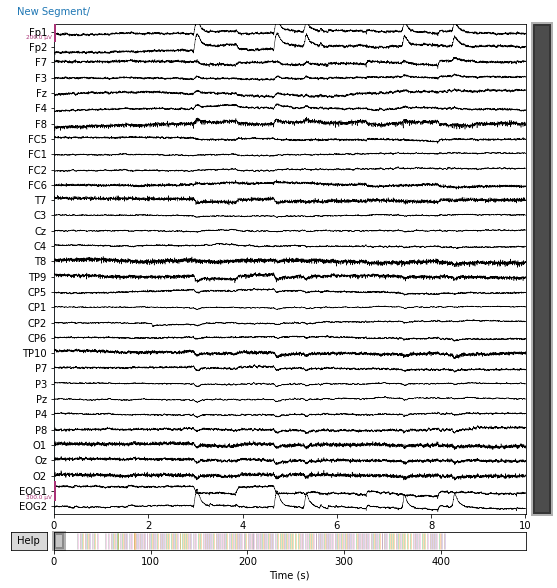

In [8]:
raw.plot(n_channels = 33, scalings = {'eeg': 100e-6});

### Filter your data (highpass; 0.1 Hz; lowpass: 40 Hz); re-plot your data to inspect whether things look sensible

In [9]:
# high-pass filtering the data at 0.1 Hz and subsequently low-pass filtering at 40 Hz
raw = raw.filter(0.1, None)
raw = raw.filter(None, 40)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 33001 samples (33.001 sec)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 sec)



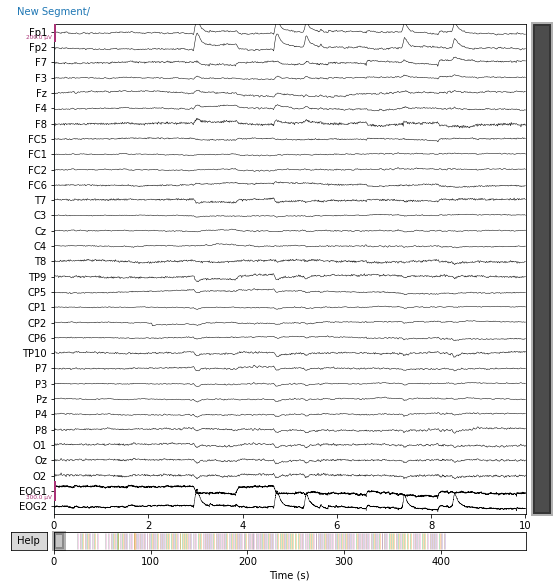

In [10]:
raw.plot(n_channels = 33, scalings = {'eeg': 100e-6});

In [11]:
raw.info['bads'] = ['Fp1', 'Fp2']

#### Epoch your data:
    a. First, get a view of the event structure of your dataset: This is a bit more tricky with BrainVision data, so try to make use of mne.events_from_annotations() and then extract all the unique trigger-values from the structure that gives you
    b. Set up an event_id-dictionary with the relevant event labels (make sure to only include those labels for which triggers are also present in your data):

In [12]:
events, _  = mne.events_from_annotations(raw)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 21', 'Stimulus/S 22', 'Stimulus/S 31', 'Stimulus/S 32']


In [13]:
np.unique(events[:,2])

array([   11,    12,    21,    22,    31,    32, 99999])

In [14]:
event_id = {'Image/cNeu': 11, # Image trigger neutral condition 
            'Image/cCon': 21, # Image trigger congruent condition  
            'Image/cInc': 31, # Image trigger incongruent condition 
            'Word/cNeu': 12, # Word trigger neutral condition
            'Word/cCon': 22, # Word trigger congruent condition
            'Word/cInc': 32 # Word trigger incongruent condition
} 

### Plot an overview of the events in your data – does it look sensible?
It looks sensible. We have 54 trials in each condition.

/var/folders/4t/gp67d4t56ysgr041byyd6shr0000gn/T/ipykernel_10903/3511924737.py:1: RuntimeWarning: event 99999 missing from event_id will be ignored
  mne.viz.plot_events(events, first_samp=raw.first_samp, event_id=event_id);


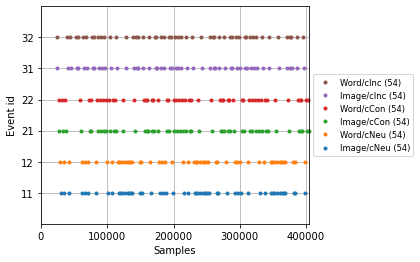

In [15]:
mne.viz.plot_events(events, first_samp=raw.first_samp, event_id=event_id);

#### Creating Epochs
**Note:** Determine sensible time window

In [16]:
# establishing time window
tmin, tmax = -0.2, 0.8

In [17]:
# rejecting all epochs with values exeeding 150 micro volts - cannot be brain data
reject = {'eeg': 150e-6}

In [18]:
# choosing only EEG channels for epoching
picks = mne.pick_types(raw.info, eeg=True, eog=False)

In [19]:
# creating the epochs using the variables created in the cell above, and timelocking to the events
# baseline time interval spans from beginning of the data (-0.2 s) to 0 s (stimulus onset)
# we use the reject variable we created earlier in order to remove artefacts
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, picks=picks,
                    baseline=(None, 0), reject=reject, preload=True, verbose = True)

Not setting metadata
Not setting metadata
324 matching events found
Setting baseline interval to [-0.2, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 324 events and 1001 original time points ...
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['FC5', 'T7']
    Rejecting  epoch based on EEG : ['FC5']
6 bad epochs dropped


### Downsample to 250 Hz

In [20]:
epochs_resampled = epochs.resample(250)

### Make a plot of the consistency of your participant’s brain responses (as measured at Oz) to all the words and another one to all the images
– does this look sensible to you?

In [21]:
img_epochs = epochs_resampled['Image']
word_epochs = epochs_resampled['Word']

Not setting metadata
Not setting metadata
159 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


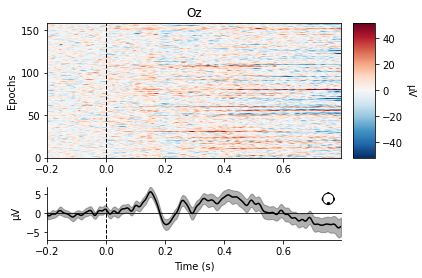

Not setting metadata
Not setting metadata
159 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


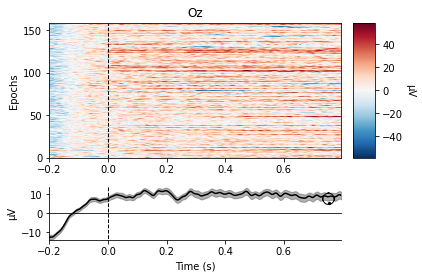

In [24]:
# plotting one channel as an example for each modality
# now the '/' used in the event IDs comes in handy! To get all epochs with image stimuli, we can index 'image' across the left/right dimension 
img_epochs.plot_image(picks=['Oz']);
word_epochs.plot_image(picks=['Oz']);

### Creating evoked variables

In [ ]:
image_evoked = img_epochs.average()
word_evoked = word_epochs.average()

combining channels using "gfp"
combining channels using "gfp"


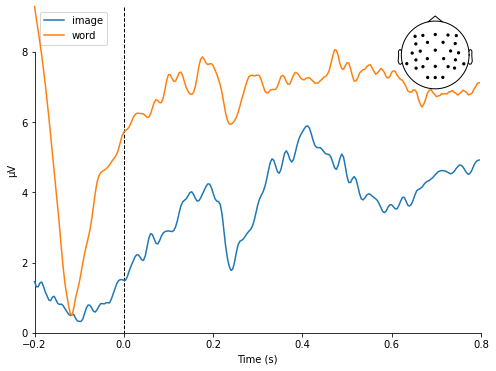

[<Figure size 576x432 with 2 Axes>]

In [ ]:
mne.viz.plot_compare_evokeds({'image': image_evoked, 'word': word_evoked},
                             legend='upper left', show_sensors='upper right')

### Eliciting response times using the triggers from the button-presses: Copy the code from the rt_code_snippet.py in the scripts-folder to your notebook and try to run it (it’s a bit dense, I know). Can you get a sensible output? If not, we’ll play around with this at a later stage.

No projector specified for this dataset. Please consider the method self.add_proj.


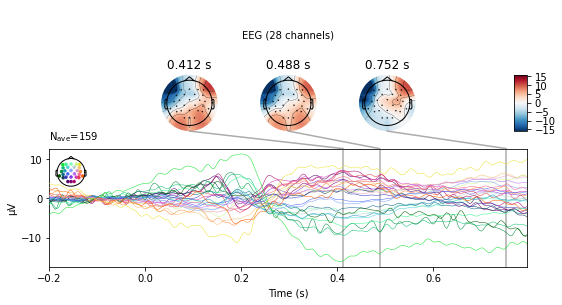

In [ ]:
image_evoked.plot_joint(picks='eeg');

No projector specified for this dataset. Please consider the method self.add_proj.


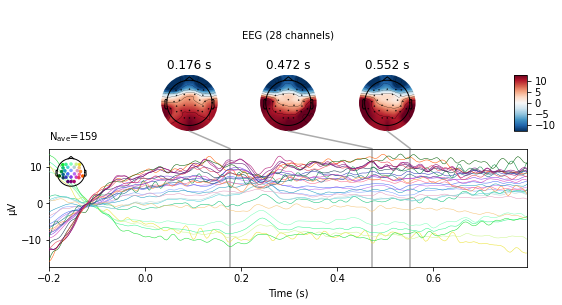

In [ ]:
word_evoked.plot_joint(picks='eeg');

As a final note, we can create contrasts (aka. difference waves) on the fly by using the combine_evoked-function (in combination with the weights=[1, -1]-parameter).

This also gives us a chance to try out one final plotting function, namely the plot_topo-function. This function plots the difference waves (or whichever traces we choose to plot) for each channel in their positions on the scalp.

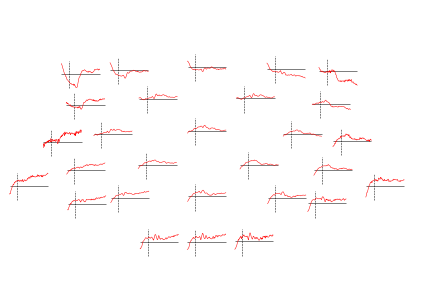

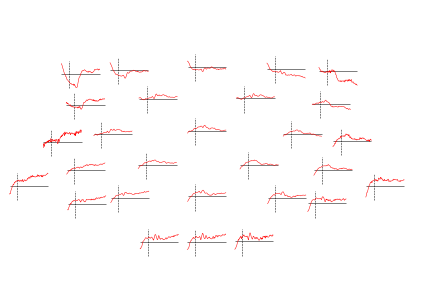

In [ ]:
evoked_diff = mne.combine_evoked([word_evoked, image_evoked], weights=[1, -1])
evoked_diff.pick_types(eeg=True).plot_topo(color='r', legend=False)